## **Data Ingestion**

In [3]:
import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re
from helpers import *

In [4]:
def get_file_paths(directory_path):
    path_list = []
    for root, directories, files in os.walk(directory_path):
        for file in files:
            # Different workflow needed for Amir next time
            # Need to ensure sessionID is updating in Madeline's logs
            if file != "logs_nome_amir.json" and (not "Logs-Workflow3" in file):
                path = os.path.join(root, file)
                path_list.append(path)
    return path_list

liam_vlad_dir = (os.getcwd() + '/data3') # Note: Sundial did not work
liam_vlad = get_file_paths(liam_vlad_dir)
all_paths = [path.replace("\\", "/") for path in liam_vlad]

print("File Paths:")
for path in all_paths:
    print(path)


File Paths:
C:/Users/Vladimir/Desktop/Everything/Work/ARLIS/development/incubator-flagon-distill/prototypes/data3/logs_nome_liam.json
C:/Users/Vladimir/Desktop/Everything/Work/ARLIS/development/incubator-flagon-distill/prototypes/data3/logs_nome_vlad.json


In [5]:
def combine_json_to_dataframe(file_paths):
    data_list = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            data_list.append(data)

    combined_data = pd.concat([pd.DataFrame(data) for data in data_list], ignore_index=True)
    return combined_data

df = combine_json_to_dataframe(all_paths)
# df = pd.read_json("data3/logs_nome_vlad.json")
df.head()

,target,path,pageUrl,pageTitle,pageReferrer,browser,clientTime,microTime,location,scrnRes,type,logType,userAction,details,userId,toolVersion,toolName,useraleVersion,sessionID
0,Window,[Window],https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062434247,0.0,"{'x': None, 'y': None}","{'width': 1440, 'height': 489}",resize,raw,True,"{'width': 1453, 'height': 865}",nobody,None,test_app,2.3.0,session_1688062135244
1,div#map.leaflet-container leaflet-touch leafle...,[div#map.leaflet-container leaflet-touch leafl...,https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062437423,0.0,"{'x': 756, 'y': 314}","{'width': 1440, 'height': 489}",click,raw,True,"{'clicks': 1, 'ctrl': False, 'alt': False, 'sh...",nobody,None,test_app,2.3.0,session_1688062135244
2,NaN,NaN,https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062437461,NaN,NaN,"{'width': 1440, 'height': 489}",viewChange,custom,True,"{'zoom': '18', 'latitude': '38.98564', 'longit...",nobody,None,test_app,2.3.0,session_1688062135244
3,path.[object SVGAnimatedString],"[path.[object SVGAnimatedString], g.[object SV...",https://nome.vgihub.geointservices.io/way/1434...,Way: ‪Reckord Armory‬ (‪143466875‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062440642,0.0,"{'x': 554, 'y': 269}","{'width': 1440, 'height': 489}",click,raw,True,"{'clicks': 1, 'ctrl': False, 'alt': False, 'sh...",nobody,None,test_app,2.3.0,session_1688062135244
4,NaN,NaN,https://nome.vgihub.geointservices.io/way/2340...,Way: ‪McKeldin Library‬ (‪23408799‬) | MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'firefox', 'version': '114.0.0'}",1688062441543,NaN,NaN,"{'width': 1440, 'height': 489}",visit,custom,True,"{'class': 'Way', 'id': '23408799', 'name': 'Mc...",nobody,None,test_app,2.3.0,session_1688062135244


## Preprocessing

In [7]:
def get_partition(log, partition_elements):
    name = log['details']['name']
    if name in set(partition_elements):
        return name
    else:
        return "Other"
    print("uh oh")
    return "uh oh"

Current visit name graph code

In [8]:
def convert_time(date_type, client_time):
    if date_type == "integer":
        return distill.epoch_to_datetime(client_time)
    elif date_type == "datetime":
        return pd.to_datetime(client_time, unit='ms', origin='unix')
    else:
        return client_time
    
def get_color_graph(log_dict, color_dict, partition_func):
    targets = []
    partition_dict = {}
    label_dict = {}
    for log in log_dict.values():
        # Append this log's name to targets
        targets.append(''.join(log['details']['name']))
        # {this path : partition type ('MD Science Center', 'National Aquarium', etc.)}
        partition_dict[targets[-1]] = partition_func(log, color_dict.keys())
        # {this path : log's "label"}
        label_dict[targets[-1]] = log['details']['name']
        
    # Make a pairwise list of the logs' paths as edges
    edges = list(nx.utils.pairwise(targets))

    # x and y are the nodes connected by the edge, and v is the capacity/direction of the edge
    graph = nx.DiGraph((x, y, {'capacity': v}) for (x, y), v in collections.Counter(edges).items())
    # Sets partition and label attributes for each node in the graph
    nx.set_node_attributes(graph, partition_dict, "partition")
    nx.set_node_attributes(graph, label_dict, "label")
    # Sets node values according to the partition of the node's log
    colors = [color_dict[p] for p in nx.get_node_attributes(graph, "partition").values()]
    # Returns a tuple containing the constructed graph (graph) and the list of colors (colors)
    return (graph, colors)

def setup(file, date_type):
    with open(file, 'r', encoding='utf-8') as json_file:
        raw_data = json.load(json_file)

    # Data = {sessionID : {logUUID : log}}
    data = {}
    curr_sess = {}
    curr_id = next(iter(raw_data))['sessionID']
    # For each log of type 'visit' or 'click', attach it to the log's uuid in the curr_sess dictionary
    for log in raw_data:
        if 'type' in log and (log['type'] == 'visit') and ('name' in log['details']):
            # If the sessionID is different from before, attach the sorted curr_sess dictionary to the curr_id in data
            # and reset it
            if log['sessionID'] != curr_id:
                data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
                curr_id = log['sessionID']
                curr_sess = {}
            # Convert clientTime to specified type and add it to the current session dictionary
            client_time = log['clientTime']
            log['clientTime'] = convert_time(date_type, client_time)
            curr_sess[distill.getUUID(log)] = log
    # Add the final session's dict to the data dict
    data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
    
    return data

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22404\1799288566.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


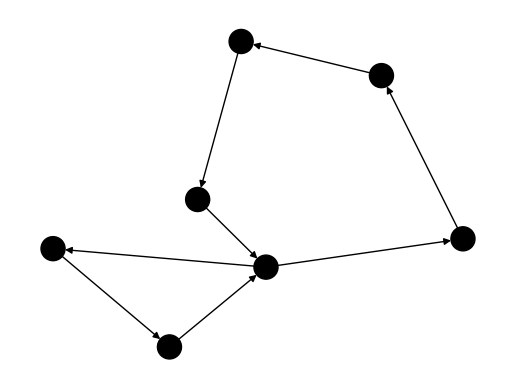

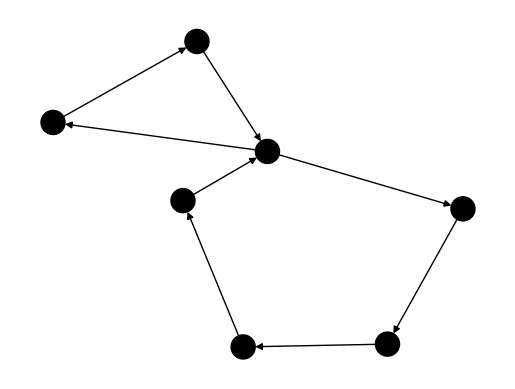

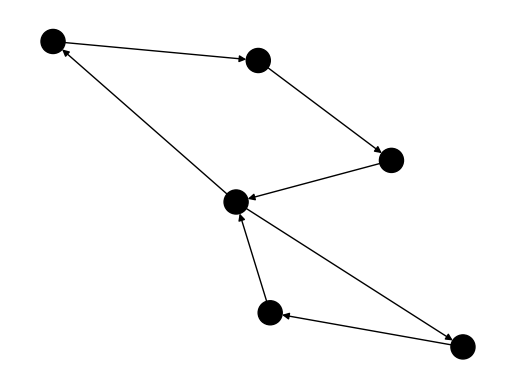

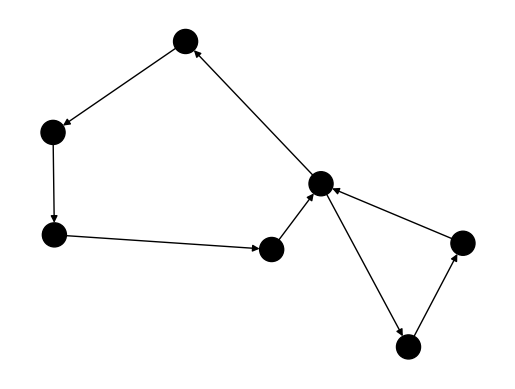

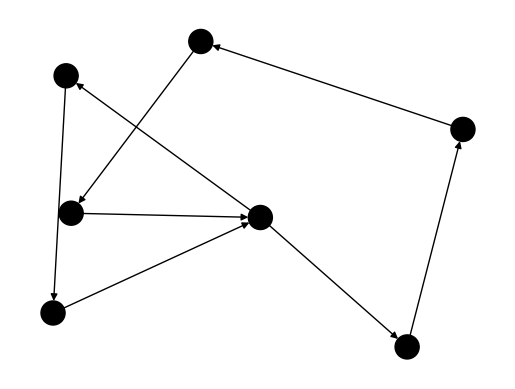

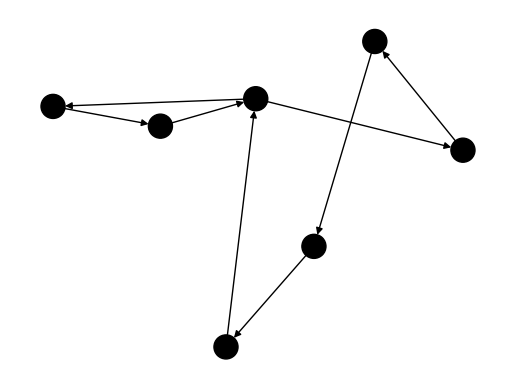

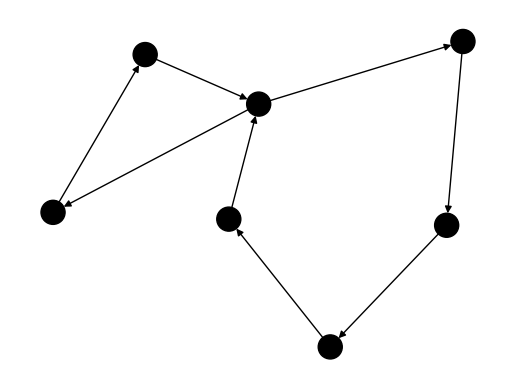

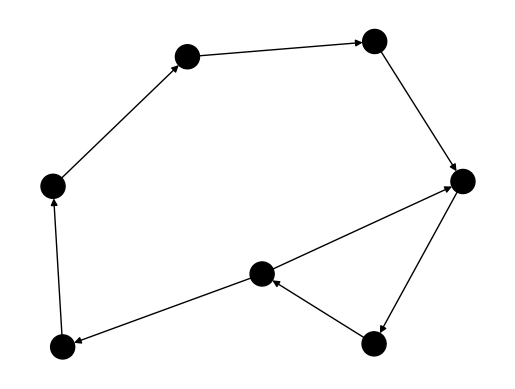

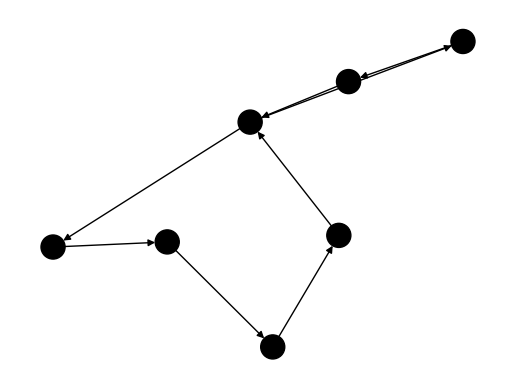

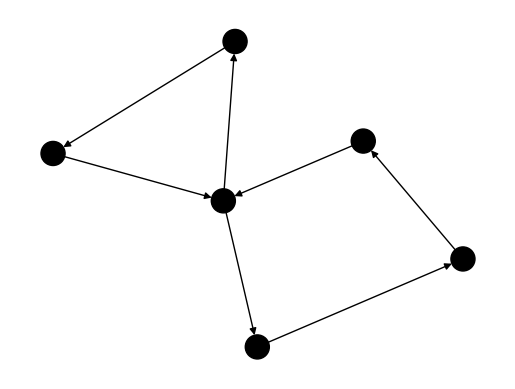

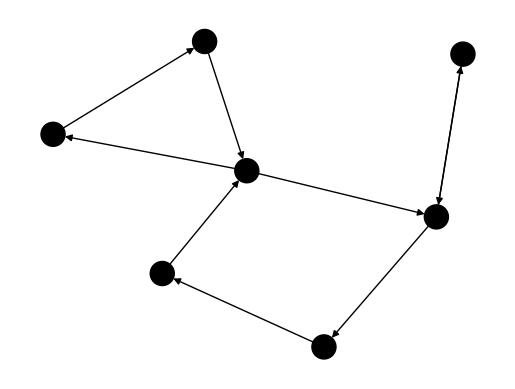

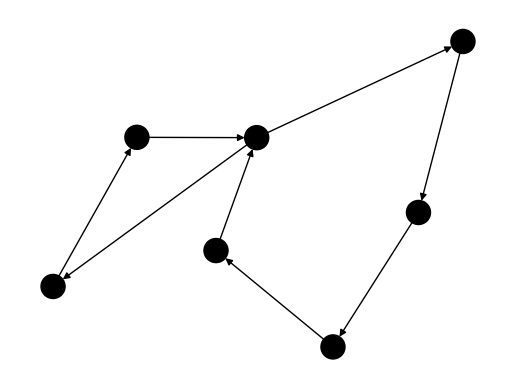

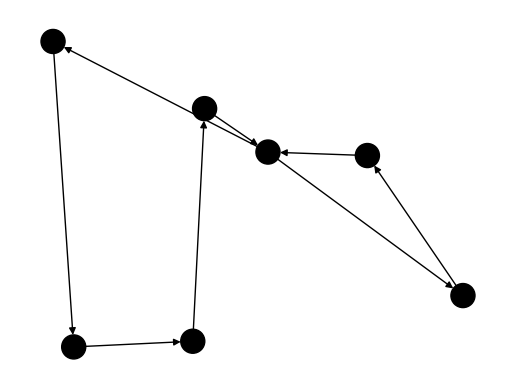

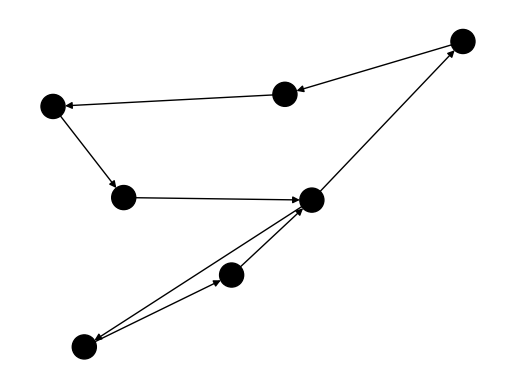

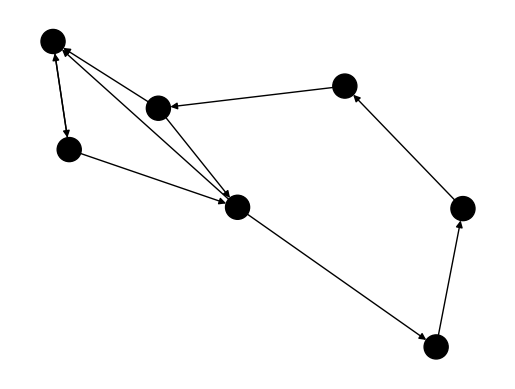

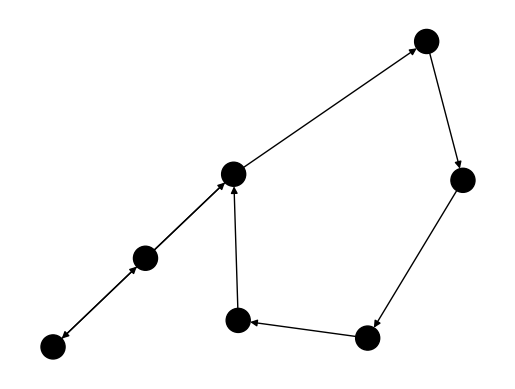

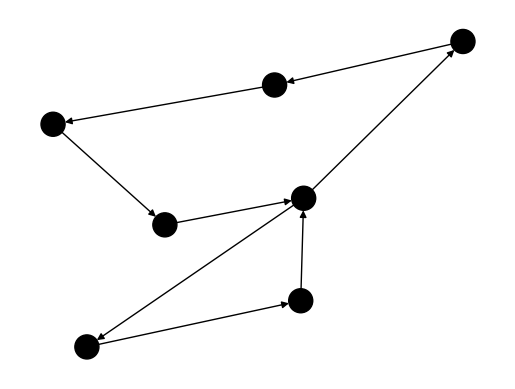

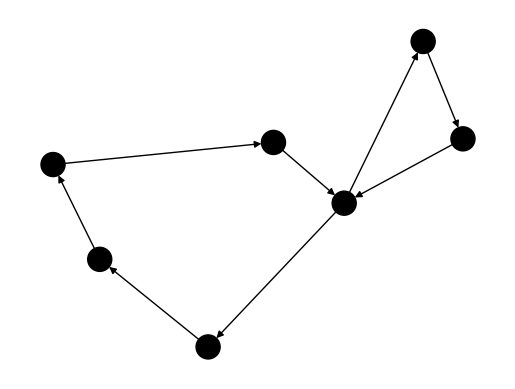

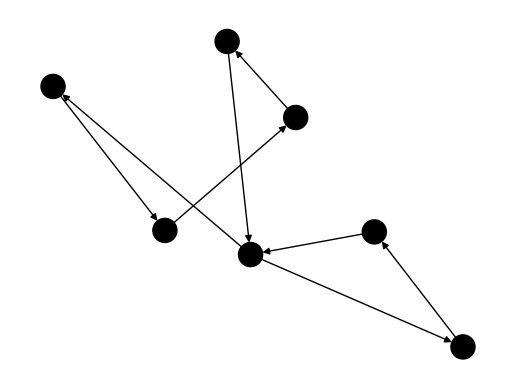

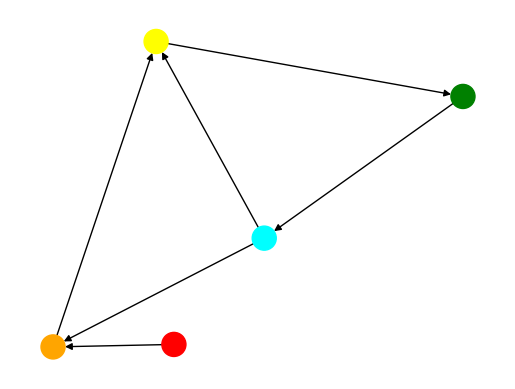

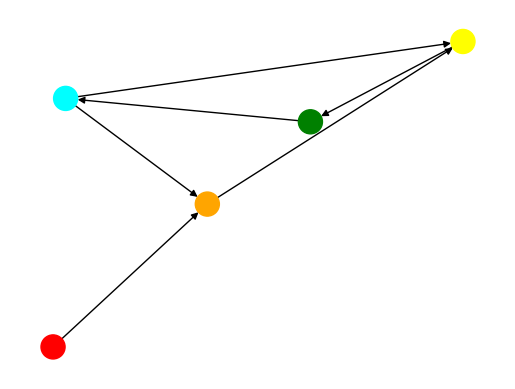

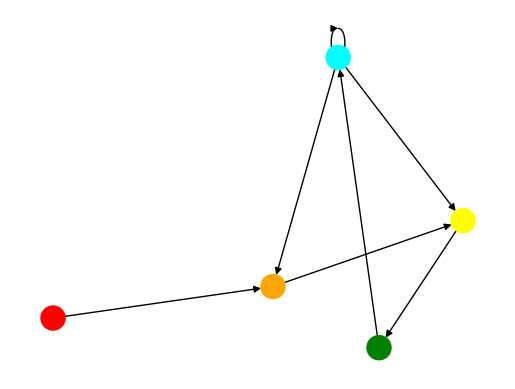

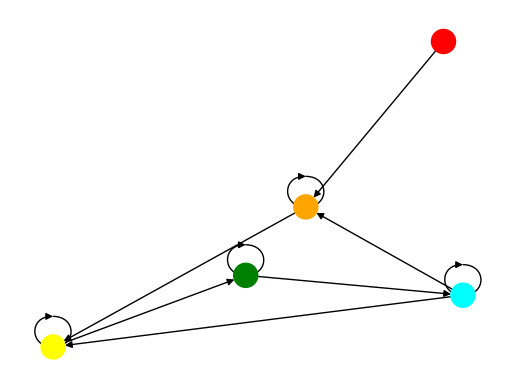

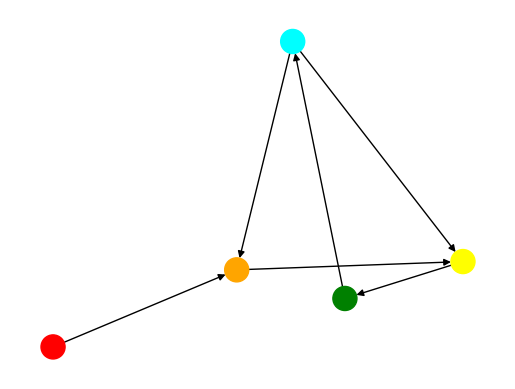

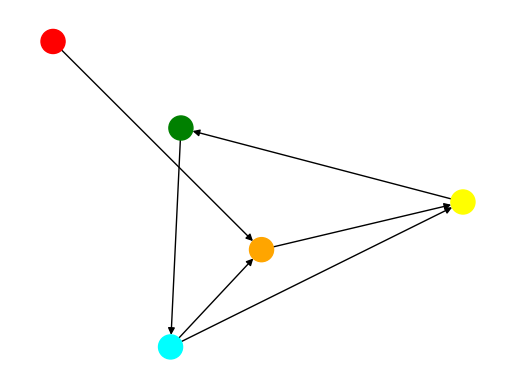

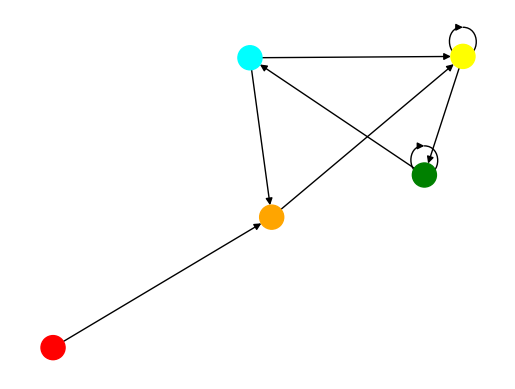

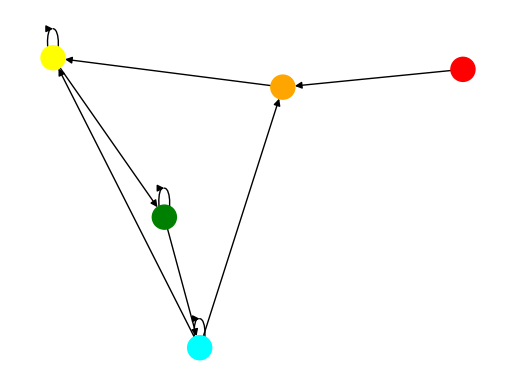

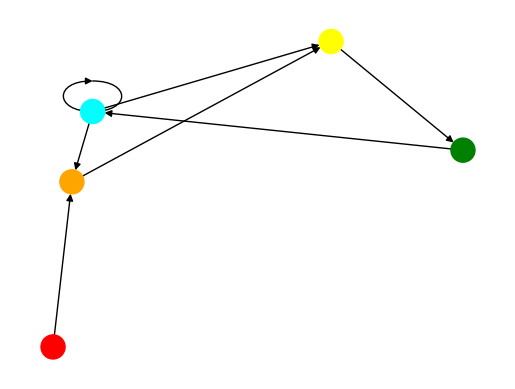

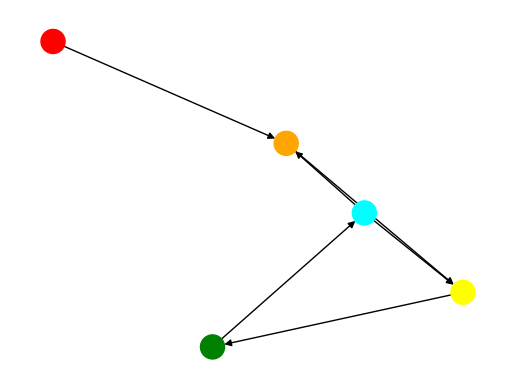

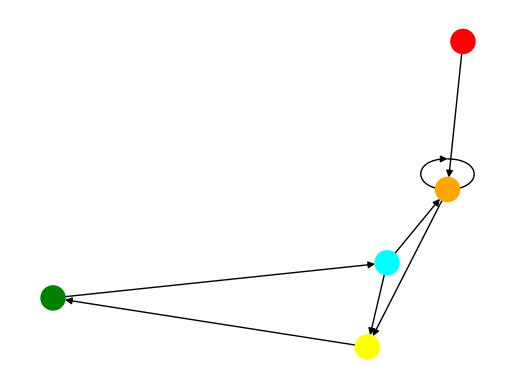

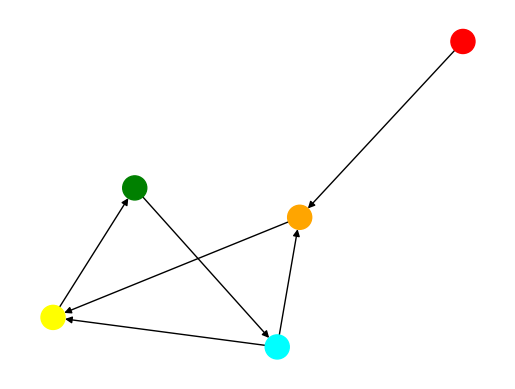

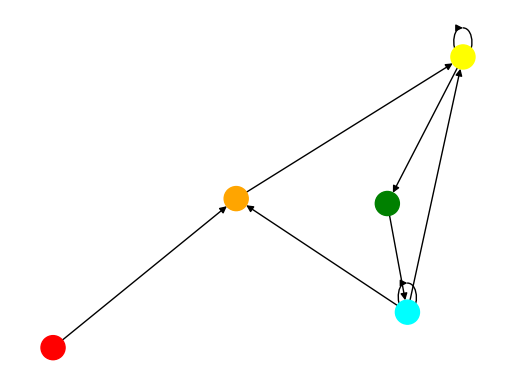

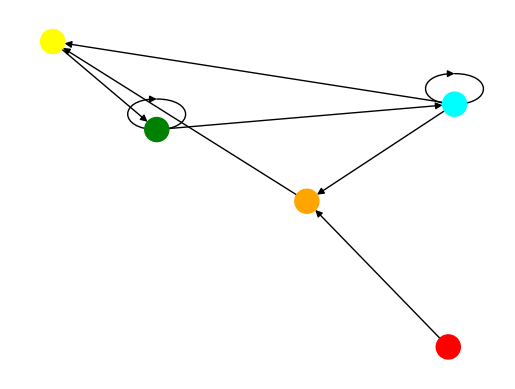

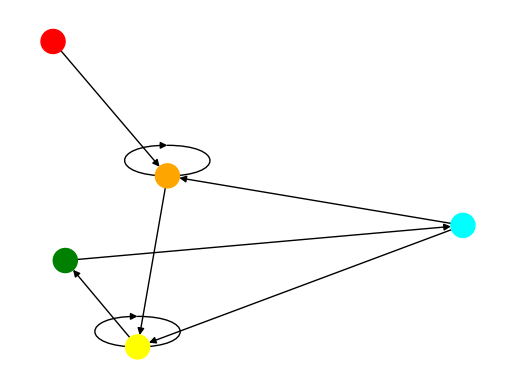

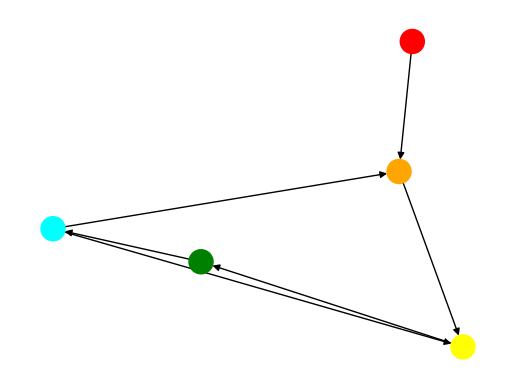

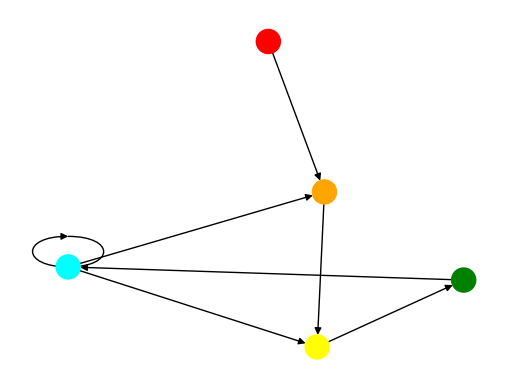

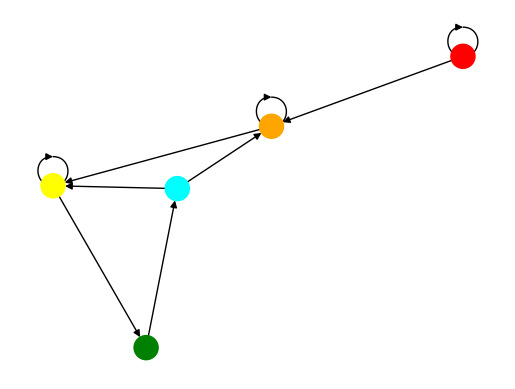

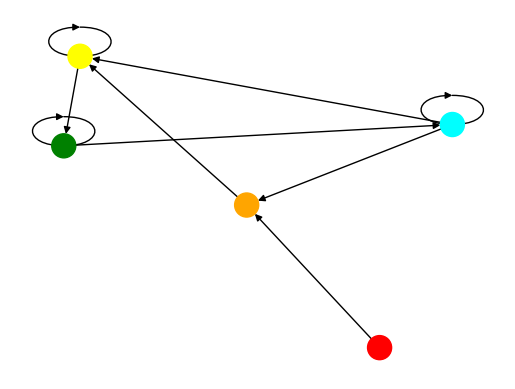

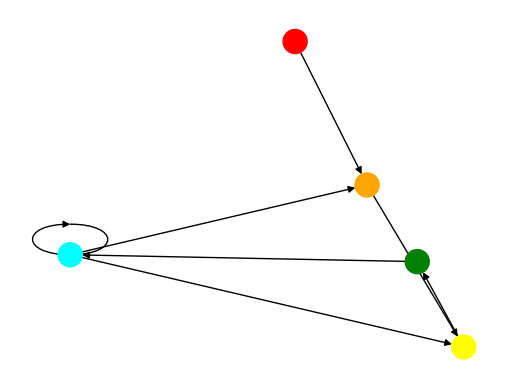

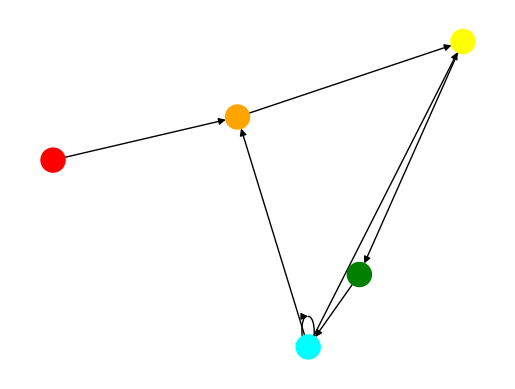

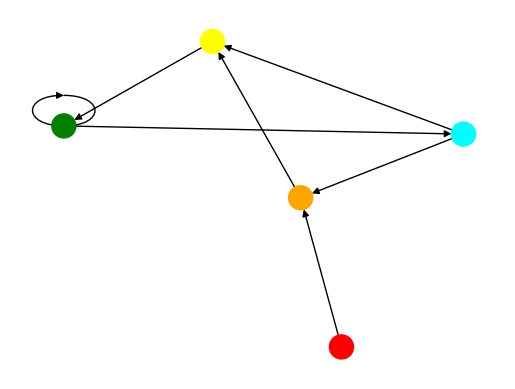

In [9]:
# Path to the logs
# files = ["data3/logs_nome_vlad.json"]
files = all_paths

# Color coding the different elements for the Sankey and Directed graphs
# color_dict = {'Other':'green', 'div.leaflet-pane leaflet-map-pane':'red'}
color_dict = {'Maryland Science Center and Planetarium':'red', 
              'USS Constellation':'orange', 'World Trade Center':'yellow', 
              'National Aquarium':'green', 'USCGC Taney':'cyan', 
              'Pratt Street Pavilion':'blue', 'Light Street Pavilion':'purple',
              'Chesapeake':'pink', 'Other':'black'}

# creating a list to store the generated directed graphs
graphs = {}

# Assembling data into a dictionary from each file
data = {}
for file in files:
    if len(data) == 0:
        data = setup(file, "datetime")
    else:
        data.update( setup(file, "datetime") )
    
for sessID,logs in data.items():
    # creating the directed graph and assigning the previously defined color-code
    (graph, colors) = get_color_graph(logs, color_dict, get_partition)
    f = plt.figure()
    # drawing the di-graph
    nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
    # adding the digraph to our previously defined 'graphs' list.
    graphs[sessID] = graph

In [11]:
print("Example of the name data we want: ", (data['session_1688066755015']['session_16880667550152023-06-29 20:16:38.223000customvisit']['details']['name'] ) ) 

Example of the name data we want:  Maryland Science Center and Planetarium


Now we have all the graphs of temporally sorted logs indexed by their sessions. The next step is turning them into lists to be fed into the model:

First, we get the important information of every log in the session

In [10]:
sess_elements = {}
for sessID,logs in data.items():
    for logID,log in logs.items():
        elem_name = log['details']['name']
        if (not sessID in sess_elements.keys()):
            sess_elements[sessID] = [ elem_name ]
        else:
            sess_elements[sessID] += [ elem_name ]

In [11]:
print("Example of a session list after extracting desired data: ", sess_elements['session_1688066755015'])

Example of a session list after extracting desired data:  ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']


7/19/2023 Experiment: Extract all various-length ordered rotations from every workflow's sess_elements to reinforce pattern catching for any length input

In [12]:
def rotate_list(lst, n):
    return lst[n:] + lst[:n]

def all_permutations(lst):
    permutations = []
    for i in range(len(lst)):
        rotated_list = rotate_list(lst, i)
        permutations.append(rotated_list)
    return permutations

input_list = sess_elements['session_1688066755015']
result = all_permutations(input_list)
print( len(result) )


12


In [13]:
def generate_sublists(input_list):
    output_list = []
    n = len(input_list)

    for i in range(n):
        for j in range(i + 1, n + 1):
            sublist = input_list[i:j]
            if len(sublist) > 1:
                output_list.append(sublist)

    return output_list

input_list = [1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5]
# input_list = sess_elements['session_1688066755015']
result = generate_sublists(input_list)
# print(result)
print(len(result))


66


## Partitioning

Much like in Prototype_2, we're just going to partition the full input sequence apart from its last element for the purposes of predicting that last element. This is so we can focus on an incremental prediction approach with higher accuracy that will be described later in the "N-Many" section of this notebook

In [40]:
import pandas as pd

# The smallest workflow we have is size 6, so anything less than that gets cut
print("Original # of tasks/sessions: ", len(data))
data = [sess_elements[sessID] for sessID in sess_elements.keys() if len(sess_elements[sessID]) > 5]
print("Refined # of tasks/sessions: ", len(data))

s = set()
for sess_lst in data:
    s.update(sess_lst)
vocab = list(s)
vocab += ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
print(vocab)

# Consider reducing the size of data to only have unique workflow lists, too.
# This would greatly reduce the number of repeated lists
all_data = []
for sess_lst in data:
    all_data += generate_sublists(sess_lst)
print(len(all_data))

Original # of tasks/sessions:  41
Refined # of tasks/sessions:  41
['National Aquarium', 'Mitchell Building', 'USCGC Taney', 'Marie Mount Hall', 'Memorial Chapel', 'Reckord Armory', 'Lee Building', 'USS Constellation', 'McKeldin Library', 'World Trade Center', 'Maryland Science Center and Planetarium', 'Sundial', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
3475


In [41]:
# Using a specific n value:
# n = 4
# inputs = [s[:-n] for s in data], targets = [s[-n:] for s in data]
# data_tups = [(s[:-n], s[-n:]) for s in data]

# Spliting the list:
data_tups = [(s[:-1], s[-1]) for s in all_data]
# print("data: ", data_tups)
df = pd.DataFrame(data_tups, columns=["inputs", "targets"])
df.head()

,inputs,targets
0,[McKeldin Library],Sundial
1,"[McKeldin Library, Sundial]",Marie Mount Hall
2,"[McKeldin Library, Sundial, Marie Mount Hall]",McKeldin Library
3,"[McKeldin Library, Sundial, Marie Mount Hall, ...",Sundial
4,"[McKeldin Library, Sundial, Marie Mount Hall, ...",Marie Mount Hall


In [42]:
first_row = df.iloc[4]
print(first_row['inputs'])
print(first_row['targets'])

['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial']
Marie Mount Hall


## **Model** (Training and Evaluation)

**Working LSTM model:**

Straight-forward approach

In [43]:
import random
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_seq):
        # Initialize hidden state and cell state
        hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
        # Convert input sequence to tensor of indices
        input_idx = [word2idx[w] for w in input_seq]
        input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)
        
        # Embed input tensor
        input_embedded = self.dropout(self.embedding(input_tensor))
        
        # Pass through LSTM layer
        lstm_out, hidden = self.lstm(input_embedded, hidden)
        
        # Pass LSTM output through linear layer to get predicted next word
        output = self.fc(lstm_out.view(len(input_seq), -1))
        return output


word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}

# Schuffle and split data 80/20 training/testing with the last kth "fold"
random.shuffle(data_tups)
k = 5
subset_size = len(data_tups) // k
data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]
val_data = data_subsets[ (k-1) ]
train_data = [tup for i, subset in enumerate(data_subsets) for tup in subset if i != (k-1)]

# Define the model
lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())

for epoch in range(501):
    for i,t in train_data:
        lstm.zero_grad()
        hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
        output = lstm(i)
        predicted_idx = output[-1].unsqueeze(0)
        target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
        loss = loss_fn(predicted_idx, target_idx)
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        
# Evaluate the model on the validation data
val_loss = 0
with torch.no_grad():
    for i,t in val_data:
        hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
        output = lstm(i)
        predicted_idx = output[-1].unsqueeze(0)
        target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
        loss = loss_fn(predicted_idx, target_idx)
        val_loss += loss.item()
    
val_loss /= len(val_data)
print(f"Validation Loss: {val_loss}")

# Save the model
torch.save(lstm, 'model_4.pth')

Epoch 0, Loss: 1.0733493566513062
Epoch 50, Loss: 0.05839581415057182
Epoch 100, Loss: 0.010032466612756252
Epoch 150, Loss: 0.0099741630256176
Epoch 200, Loss: 0.012595273554325104
Epoch 250, Loss: 0.023971375077962875
Epoch 300, Loss: 0.013180862180888653
Epoch 350, Loss: 0.014515280723571777
Epoch 400, Loss: 0.010561170987784863
Epoch 450, Loss: 0.014442315325140953
Epoch 499, Loss: 0.018802152946591377
Validation Loss: 0.3763253607482959


Attempting the same as before, but **now with k-fold validation to get the best trained model:**

In [22]:
# import random
# import sys

# # Shuffle data tuples
# random.shuffle(data_tups)

# # Define the number of folds
# k = 5

# # Divide data tuples into k subsets of equal size
# subset_size = len(data_tups) // k
# data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]

# best_loss = float(sys.maxsize)
# best_lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
# best_val_fold = []
# best_train_fold = []
# # Train and validate model on each subset
# for fold in range(k):
#     # Define the model
#     lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
#     loss_fn = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(lstm.parameters())

#     # Get the training and validation data for this fold
#     val_data = data_subsets[fold]
#     train_data = [tup for i, subset in enumerate(data_subsets) for tup in subset if i != fold]

#     # Train the model on the training data
#     for epoch in range(1001):
#         for i,t in train_data:
#             lstm.zero_grad()
#             hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
#             output = lstm(i)
#             predicted_idx = output[-1].unsqueeze(0)
#             target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
#             loss = loss_fn(predicted_idx, target_idx)
#             loss.backward()
#             optimizer.step()

#         if epoch % 100 == 0:
#             print(f"Fold {fold+1}, Epoch {epoch}, Training Loss: {loss.item()}")

#     # Evaluate the model on the validation data
#     val_loss = 0
#     with torch.no_grad():
#         for i,t in val_data:
#             hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
#             output = lstm(i)
#             predicted_idx = output[-1].unsqueeze(0)
#             target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
#             loss = loss_fn(predicted_idx, target_idx)
#             val_loss += loss.item()
    
#     val_loss /= len(val_data)
#     if val_loss < best_loss:
#         best_loss = val_loss
#         best_lstm = lstm
#         best_val_fold = val_data
#         best_train_fold = train_data
    
#     print(f"Fold {fold+1}, Validation Loss: {val_loss}")
#     print()

# torch.save(best_lstm, 'model_2.pth')

## Model Performance

In [44]:
import torch

lstm = torch.load('model_4.pth')

print("Size of the validation set for our confusion matrix: ", len(val_data))

Size of the validation set for our confusion matrix:  695


Attempted to make a confusion matrix, but output can't be modelled as such when there's so many possibilties of multi-dimensional outputs.

In the following confusion matrix, we are displaying where the validation set's true labels intersect/diverge from the model's predictions. More shaded boxes and values **on the diagonal** means the model is making the **correct predictions**. More shaded boxes and values **anywhere else** means the **model is confused** with some of the validation set's inputs on what the right prediction should be.

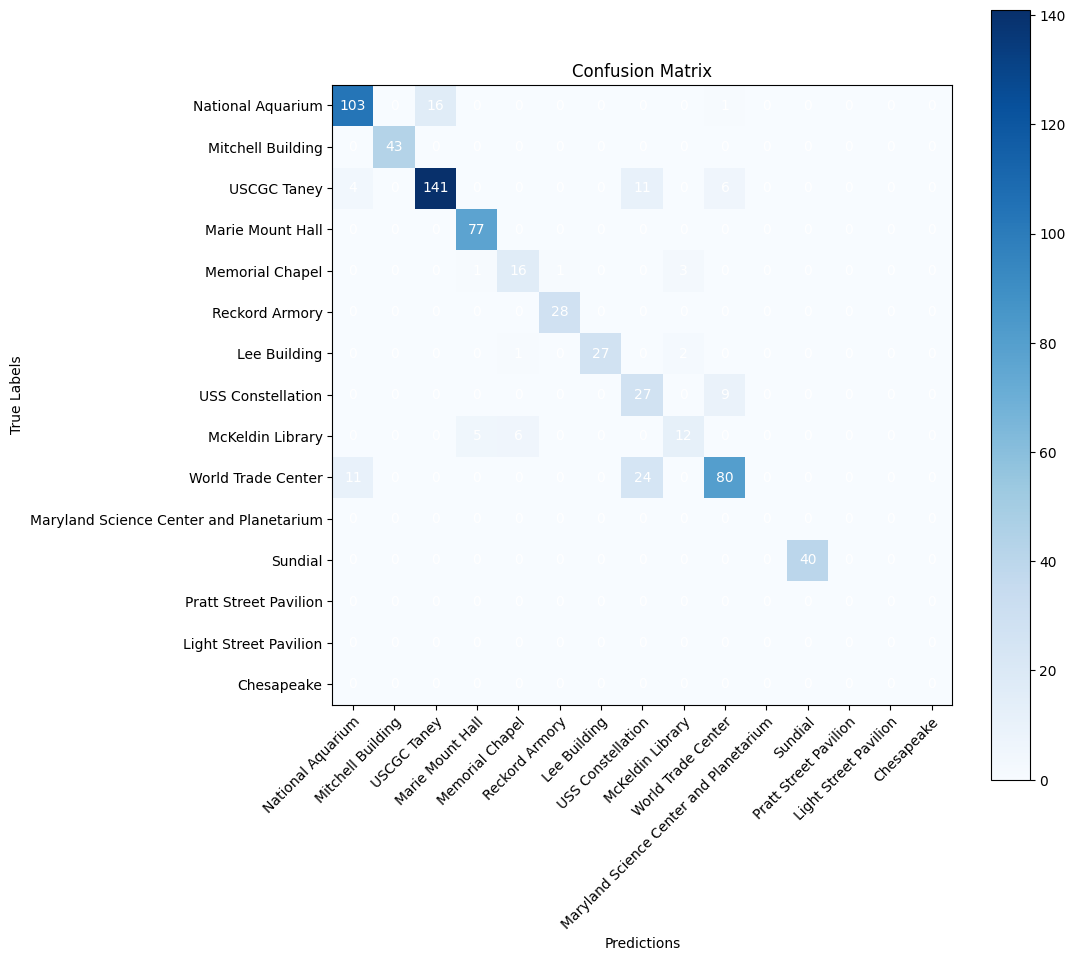

In [45]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
lstm.eval()

# Create variables to store predictions and ground truth labels
predictions = []
labels = []
# Loop through the test dataset and make predictions
for i, t in val_data:
    output = lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_label = idx2word[predicted_idx]
    label = t
    predictions.append(predicted_label)
    labels.append(label)

conf_mat = confusion_matrix(labels, predictions, labels=vocab)
# Print the confusion matrix
# print(np.array2string(conf_mat, separator=', '))

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(conf_mat, cmap='Blues')

# Set ticks for x and y axis
ax.set_xticks(np.arange(len(vocab)))
ax.set_yticks(np.arange(len(vocab)))

# Set labels for x and y axis
ax.set_xlabel('Predictions')
ax.set_ylabel('True Labels')
ax.set_xticklabels(vocab)
ax.set_yticklabels(vocab)

# Rotate the x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over the data and create annotations for each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")

# Set title and colorbar
ax.set_title("Confusion Matrix")
fig.colorbar(im)
plt.show()

Some specific expected model targets for their respective inputs:

In [46]:
# Test the model on a new input sequence
# ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium']
input_seqs = [['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall']]
for i in input_seqs:
    output = lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_word = idx2word[predicted_idx]
    print(f'\nInput sequence: {i}, \nPredicted next word: {predicted_word}')
# Should be 'World Trade Center'
# Should be 'Memorial Chapel'


Input sequence: ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], 
Predicted next word: World Trade Center

Input sequence: ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall'], 
Predicted next word: Memorial Chapel


So the expected targets are hit when the model is given the right inputs. But what about other inputs?

In [47]:
input_seqs = [['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']]
for i in input_seqs:
    output = lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_word = idx2word[predicted_idx]
    print(f'Input sequence: {i}, Predicted next word: {predicted_word}')
#Should expect: USCGC Taney for all of them, because that's the only output there can be right now

Input sequence: ['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next word: USCGC Taney
Input sequence: ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next word: USCGC Taney
Input sequence: ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next word: National Aquarium
Input sequence: ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next word: National Aquarium


As expected, when presented with information completely outside the training set, the model will not know what to do. This is a problem with the amount of data we have, not the model

## N-Many Application

The way this prototype diverges from the rest is that it is built to detect patterns in the data of any length and will use that information to predict the next "n-many" elements the user might interact with.

The following method outputs a sequence of "n"-many predictions when given an input of our vocabulary's strings. It works by: 

(1) predicting the next string, given the original input sequence, 

(2) making a new input by dropping the first element of the last input and appending the string predicted in part (1) to form a new input, 

(3) predicting the next string, given the new input sequence made by part (2), appending it to an output list starting with the prediction from part (1), and

(4) repeating parts (2) and (3) for "n" iterations before returning the output list

In [48]:
def generate_sequence(model, initial_input, n):
    output_sequence = []

    # Initialize hidden state and cell state
    hidden = (torch.zeros(1, 1, model.hidden_size), torch.zeros(1, 1, model.hidden_size))

    for i in range(n):
        # Predict the next word given the current input sequence
        output = model(initial_input)
        predicted_idx = torch.argmax(output[-1], dim=-1)

        # Convert predicted index to word
        predicted_word = idx2word[predicted_idx.item()]
        output_sequence.append(predicted_word)

        # Update the input for the next iteration
        initial_input = initial_input[1:] + [predicted_word]

    return output_sequence


In [49]:
# Test the model on a new input sequence
# ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium']
input_seqs = [['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall']]
n_predictions = 6
for i in input_seqs:
    n = len(i)
    predicted_sequence = generate_sequence(lstm, i, n)
    print(f'\nInput sequence: {i}, \nPredicted next n-many: {predicted_sequence}')
# Should be ['World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']
# Should be ['Memorial Chapel', 'Lee Building', 'Reckord Armory', 'Mitchell Building', 'Marie Mount Hall, (McKeldin/Memorial Chapel)']


Input sequence: ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], 
Predicted next n-many: ['World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']

Input sequence: ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall'], 
Predicted next n-many: ['Memorial Chapel', 'Lee Building', 'Reckord Armory', 'Mitchell Building', 'Marie Mount Hall', 'McKeldin Library']


As we see, It works!!! Now we just need to convert these words to graphs.